## CKD with CIFAR100

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss

In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
num_epochs = 240  # 200
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [4]:
# # Load IdenProf dataset
# train_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/train'
# test_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/test'
# trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

trainloader, testloader  = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
# teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = torchvision.models.resnet18(weights=None).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
teacher_model.fc = nn.Linear(512, num_classes)
student_model = torchvision.models.resnet18(weights=None)
student_model.fc = nn.Linear(512, num_classes)


In [6]:
# # Instantiate the models
# ###################### Testing 2 ######################
# # Create instances of your models
# teacher_model = Teacher()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = Student()

In [6]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

100%|████████████████████████████████████████████████████████████████████████| 782/782 [05:27<00:00,  2.39it/s]


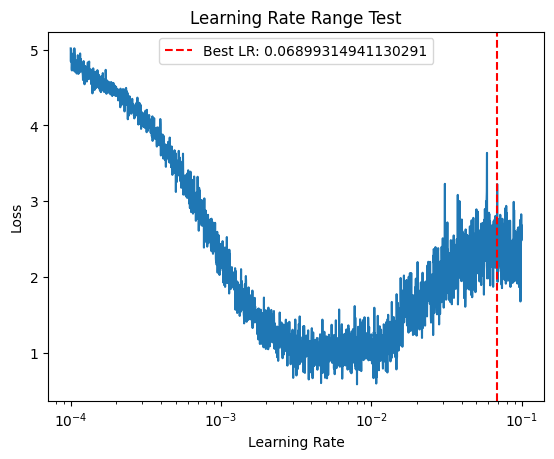

Best learning rate: 0.06899314941130291
0.06899314941130291


In [9]:
batch_size = 16  #to find the optimal learning rate
teacher_best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(teacher_best_lr)

100%|████████████████████████████████████████████████████████████████████████| 782/782 [03:52<00:00,  3.37it/s]


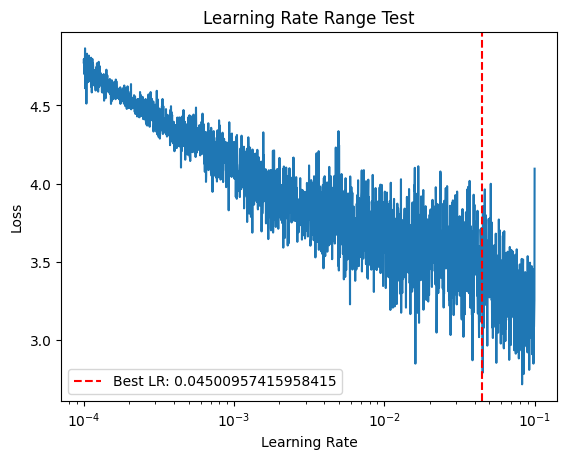

Best learning rate: 0.04500957415958415
0.04500957415958415


In [10]:
student_best_lr = train_teacher(student_model, trainloader, criterion, student_optimizer, student_scheduler, device, num_epochs=3)  
print(student_best_lr)

In [7]:
teacher_learning_rate = 0.06899314941130291
student_learning_rate = 0.04500957415958415


In [8]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [12]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, student_optimizer, student_scheduler, device, alpha, temperature, num_epochs=num_epochs)


 13%|█████████▏                                                              | 100/782 [01:12<08:08,  1.40it/s]

[1, 100] loss: 3.601


 26%|██████████████████▍                                                     | 200/782 [02:24<06:42,  1.45it/s]

[1, 200] loss: 3.366


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:40,  1.42it/s]

[1, 300] loss: 3.258


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:41,  1.36it/s]

[1, 400] loss: 3.177


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:12,  1.46it/s]

[1, 500] loss: 3.096


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:26<02:55,  1.04it/s]

[1, 600] loss: 2.972


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [09:04<01:22,  1.00s/it]

[1, 700] loss: 2.891


 13%|█████████▏                                                              | 100/782 [01:12<08:25,  1.35it/s]

[2, 100] loss: 2.732


 26%|██████████████████▍                                                     | 200/782 [02:25<07:18,  1.33it/s]

[2, 200] loss: 2.703


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:57,  1.35it/s]

[2, 300] loss: 2.604


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:48,  1.32it/s]

[2, 400] loss: 2.528


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:18,  1.42it/s]

[2, 500] loss: 2.455


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:13,  1.36it/s]

[2, 600] loss: 2.391


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:58,  1.40it/s]

[2, 700] loss: 2.298


 13%|█████████▏                                                              | 100/782 [01:12<08:08,  1.39it/s]

[3, 100] loss: 2.135


 26%|██████████████████▍                                                     | 200/782 [02:25<06:50,  1.42it/s]

[3, 200] loss: 2.071


 38%|███████████████████████████▌                                            | 300/782 [03:38<06:08,  1.31it/s]

[3, 300] loss: 2.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:27,  1.43it/s]

[3, 400] loss: 1.958


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:27,  1.36it/s]

[3, 500] loss: 1.895


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:18,  1.32it/s]

[3, 600] loss: 1.890


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:29<01:00,  1.35it/s]

[3, 700] loss: 1.790


 13%|█████████▏                                                              | 100/782 [01:13<07:59,  1.42it/s]

[4, 100] loss: 1.609


 26%|██████████████████▍                                                     | 200/782 [02:25<07:24,  1.31it/s]

[4, 200] loss: 1.617


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:39,  1.42it/s]

[4, 300] loss: 1.591


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:42,  1.35it/s]

[4, 400] loss: 1.572


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:28,  1.35it/s]

[4, 500] loss: 1.550


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:13,  1.36it/s]

[4, 600] loss: 1.486


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:02,  1.30it/s]

[4, 700] loss: 1.483


 13%|█████████▏                                                              | 100/782 [01:12<08:19,  1.37it/s]

[5, 100] loss: 1.299


 26%|██████████████████▍                                                     | 200/782 [02:24<07:05,  1.37it/s]

[5, 200] loss: 1.275


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:58,  1.35it/s]

[5, 300] loss: 1.294


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:35,  1.38it/s]

[5, 400] loss: 1.288


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:28,  1.35it/s]

[5, 500] loss: 1.276


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:07,  1.43it/s]

[5, 600] loss: 1.249


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:55,  1.48it/s]

[5, 700] loss: 1.260


 13%|█████████▏                                                              | 100/782 [01:12<08:23,  1.35it/s]

[6, 100] loss: 1.018


 26%|██████████████████▍                                                     | 200/782 [02:25<07:09,  1.35it/s]

[6, 200] loss: 1.051


 38%|███████████████████████████▌                                            | 300/782 [03:38<06:10,  1.30it/s]

[6, 300] loss: 1.061


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:33,  1.40it/s]

[6, 400] loss: 1.057


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:12,  1.46it/s]

[6, 500] loss: 1.065


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:10,  1.40it/s]

[6, 600] loss: 1.048


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:01,  1.32it/s]

[6, 700] loss: 1.032


 13%|█████████▏                                                              | 100/782 [01:12<08:21,  1.36it/s]

[7, 100] loss: 0.818


 26%|██████████████████▍                                                     | 200/782 [02:24<06:52,  1.41it/s]

[7, 200] loss: 0.832


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:54,  1.36it/s]

[7, 300] loss: 0.836


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:42,  1.35it/s]

[7, 400] loss: 0.865


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:18,  1.42it/s]

[7, 500] loss: 0.861


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:14,  1.35it/s]

[7, 600] loss: 0.849


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<01:00,  1.36it/s]

[7, 700] loss: 0.851


 13%|█████████▏                                                              | 100/782 [01:12<08:04,  1.41it/s]

[8, 100] loss: 0.635


 26%|██████████████████▍                                                     | 200/782 [02:25<07:07,  1.36it/s]

[8, 200] loss: 0.639


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:25,  1.48it/s]

[8, 300] loss: 0.652


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:28,  1.42it/s]

[8, 400] loss: 0.651


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:14,  1.45it/s]

[8, 500] loss: 0.664


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:14<02:10,  1.39it/s]

[8, 600] loss: 0.682


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:59,  1.37it/s]

[8, 700] loss: 0.675


 13%|█████████▏                                                              | 100/782 [01:12<08:23,  1.35it/s]

[9, 100] loss: 0.459


 26%|██████████████████▍                                                     | 200/782 [02:24<06:54,  1.41it/s]

[9, 200] loss: 0.450


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:42,  1.41it/s]

[9, 300] loss: 0.448


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:41,  1.36it/s]

[9, 400] loss: 0.486


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:15,  1.44it/s]

[9, 500] loss: 0.501


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:18,  1.32it/s]

[9, 600] loss: 0.489


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:58,  1.40it/s]

[9, 700] loss: 0.507


 13%|█████████▏                                                              | 100/782 [01:12<07:44,  1.47it/s]

[10, 100] loss: 0.331


 26%|██████████████████▍                                                     | 200/782 [02:25<07:04,  1.37it/s]

[10, 200] loss: 0.309


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:40,  1.42it/s]

[10, 300] loss: 0.316


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:28,  1.42it/s]

[10, 400] loss: 0.316


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:23,  1.39it/s]

[10, 500] loss: 0.329


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:12,  1.37it/s]

[10, 600] loss: 0.327


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:59,  1.37it/s]

[10, 700] loss: 0.341


 13%|█████████▏                                                              | 100/782 [01:12<08:23,  1.35it/s]

[11, 100] loss: 0.237


 26%|██████████████████▍                                                     | 200/782 [02:24<06:49,  1.42it/s]

[11, 200] loss: 0.209


 38%|███████████████████████████▌                                            | 300/782 [03:37<06:01,  1.34it/s]

[11, 300] loss: 0.211


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:30,  1.41it/s]

[11, 400] loss: 0.211


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:25,  1.37it/s]

[11, 500] loss: 0.214


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:14<02:13,  1.36it/s]

[11, 600] loss: 0.213


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<01:01,  1.33it/s]

[11, 700] loss: 0.220


 13%|█████████▏                                                              | 100/782 [01:12<08:00,  1.42it/s]

[12, 100] loss: 0.164


 26%|██████████████████▍                                                     | 200/782 [02:24<07:00,  1.38it/s]

[12, 200] loss: 0.154


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:53,  1.36it/s]

[12, 300] loss: 0.154


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:29,  1.42it/s]

[12, 400] loss: 0.152


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:32,  1.33it/s]

[12, 500] loss: 0.147


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:14,  1.35it/s]

[12, 600] loss: 0.157


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:00,  1.36it/s]

[12, 700] loss: 0.149


 13%|█████████▏                                                              | 100/782 [01:12<08:15,  1.38it/s]

[13, 100] loss: 0.128


 26%|██████████████████▍                                                     | 200/782 [02:24<06:45,  1.44it/s]

[13, 200] loss: 0.119


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:57,  1.35it/s]

[13, 300] loss: 0.118


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:38,  1.37it/s]

[13, 400] loss: 0.115


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:31,  1.33it/s]

[13, 500] loss: 0.119


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:08,  1.42it/s]

[13, 600] loss: 0.120


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:59,  1.37it/s]

[13, 700] loss: 0.119


 13%|█████████▏                                                              | 100/782 [01:12<07:58,  1.42it/s]

[14, 100] loss: 0.104


 26%|██████████████████▍                                                     | 200/782 [02:25<07:10,  1.35it/s]

[14, 200] loss: 0.098


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:43,  1.40it/s]

[14, 300] loss: 0.098


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:49,  1.32it/s]

[14, 400] loss: 0.101


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:28,  1.35it/s]

[14, 500] loss: 0.102


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:12,  1.37it/s]

[14, 600] loss: 0.103


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:58,  1.41it/s]

[14, 700] loss: 0.101


 13%|█████████▏                                                              | 100/782 [01:13<08:35,  1.32it/s]

[15, 100] loss: 0.090


 26%|██████████████████▍                                                     | 200/782 [02:25<06:53,  1.41it/s]

[15, 200] loss: 0.089


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:49,  1.38it/s]

[15, 300] loss: 0.088


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:42,  1.35it/s]

[15, 400] loss: 0.089


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:17,  1.43it/s]

[15, 500] loss: 0.090


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:13,  1.36it/s]

[15, 600] loss: 0.092


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:29<01:00,  1.35it/s]

[15, 700] loss: 0.093


 13%|█████████▏                                                              | 100/782 [01:12<08:30,  1.34it/s]

[16, 100] loss: 0.088


 26%|██████████████████▍                                                     | 200/782 [02:24<06:58,  1.39it/s]

[16, 200] loss: 0.085


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:43,  1.40it/s]

[16, 300] loss: 0.080


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:17,  1.48it/s]

[16, 400] loss: 0.084


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:26,  1.36it/s]

[16, 500] loss: 0.085


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:04,  1.47it/s]

[16, 600] loss: 0.085


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:00,  1.35it/s]

[16, 700] loss: 0.083


 13%|█████████▏                                                              | 100/782 [01:12<08:18,  1.37it/s]

[17, 100] loss: 0.079


 26%|██████████████████▍                                                     | 200/782 [02:24<07:01,  1.38it/s]

[17, 200] loss: 0.079


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:51,  1.37it/s]

[17, 300] loss: 0.077


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:28,  1.42it/s]

[17, 400] loss: 0.077


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:25,  1.37it/s]

[17, 500] loss: 0.075


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:14,  1.36it/s]

[17, 600] loss: 0.075


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:57,  1.42it/s]

[17, 700] loss: 0.076


 13%|█████████▏                                                              | 100/782 [01:13<08:30,  1.34it/s]

[18, 100] loss: 0.074


 26%|██████████████████▍                                                     | 200/782 [02:25<07:16,  1.33it/s]

[18, 200] loss: 0.072


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:43,  1.40it/s]

[18, 300] loss: 0.072


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:42,  1.35it/s]

[18, 400] loss: 0.073


 64%|██████████████████████████████████████████████                          | 500/782 [06:04<03:12,  1.46it/s]

[18, 500] loss: 0.070


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:17<02:15,  1.34it/s]

[18, 600] loss: 0.073


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:29<00:57,  1.43it/s]

[18, 700] loss: 0.072


 13%|█████████▏                                                              | 100/782 [01:12<08:04,  1.41it/s]

[19, 100] loss: 0.071


 26%|██████████████████▍                                                     | 200/782 [02:25<07:08,  1.36it/s]

[19, 200] loss: 0.070


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:53,  1.36it/s]

[19, 300] loss: 0.070


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:33,  1.40it/s]

[19, 400] loss: 0.068


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:32,  1.33it/s]

[19, 500] loss: 0.069


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:13,  1.36it/s]

[19, 600] loss: 0.069


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:59,  1.39it/s]

[19, 700] loss: 0.068


 13%|█████████▏                                                              | 100/782 [01:13<08:16,  1.37it/s]

[20, 100] loss: 0.067


 26%|██████████████████▍                                                     | 200/782 [02:25<07:08,  1.36it/s]

[20, 200] loss: 0.067


 38%|███████████████████████████▌                                            | 300/782 [03:39<05:53,  1.37it/s]

[20, 300] loss: 0.066


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:31,  1.41it/s]

[20, 400] loss: 0.067


 64%|██████████████████████████████████████████████                          | 500/782 [06:04<03:16,  1.43it/s]

[20, 500] loss: 0.065


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:17<02:17,  1.32it/s]

[20, 600] loss: 0.066


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:30<00:58,  1.40it/s]

[20, 700] loss: 0.064


 13%|█████████▏                                                              | 100/782 [01:12<08:11,  1.39it/s]

[21, 100] loss: 0.064


 26%|██████████████████▍                                                     | 200/782 [02:25<06:54,  1.40it/s]

[21, 200] loss: 0.063


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:55,  1.36it/s]

[21, 300] loss: 0.063


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:30,  1.41it/s]

[21, 400] loss: 0.065


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:27,  1.36it/s]

[21, 500] loss: 0.065


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:10,  1.39it/s]

[21, 600] loss: 0.064


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:00,  1.35it/s]

[21, 700] loss: 0.062


 13%|█████████▏                                                              | 100/782 [01:12<08:19,  1.36it/s]

[22, 100] loss: 0.063


 26%|██████████████████▍                                                     | 200/782 [02:25<06:53,  1.41it/s]

[22, 200] loss: 0.061


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:58,  1.34it/s]

[22, 300] loss: 0.059


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:35,  1.39it/s]

[22, 400] loss: 0.061


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:16,  1.44it/s]

[22, 500] loss: 0.060


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:13,  1.37it/s]

[22, 600] loss: 0.062


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:02,  1.31it/s]

[22, 700] loss: 0.060


 13%|█████████▏                                                              | 100/782 [01:12<08:09,  1.39it/s]

[23, 100] loss: 0.060


 26%|██████████████████▍                                                     | 200/782 [02:24<07:02,  1.38it/s]

[23, 200] loss: 0.060


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:37,  1.43it/s]

[23, 300] loss: 0.059


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:38,  1.37it/s]

[23, 400] loss: 0.060


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:16,  1.44it/s]

[23, 500] loss: 0.058


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:15,  1.35it/s]

[23, 600] loss: 0.059


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:57,  1.43it/s]

[23, 700] loss: 0.059


 13%|█████████▏                                                              | 100/782 [01:12<08:11,  1.39it/s]

[24, 100] loss: 0.058


 26%|██████████████████▍                                                     | 200/782 [02:24<06:57,  1.39it/s]

[24, 200] loss: 0.057


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:35,  1.44it/s]

[24, 300] loss: 0.058


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:40,  1.36it/s]

[24, 400] loss: 0.058


 64%|██████████████████████████████████████████████                          | 500/782 [06:04<03:32,  1.33it/s]

[24, 500] loss: 0.057


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:04,  1.46it/s]

[24, 600] loss: 0.059


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:29<01:01,  1.33it/s]

[24, 700] loss: 0.056


 13%|█████████▏                                                              | 100/782 [01:12<08:15,  1.38it/s]

[25, 100] loss: 0.058


 26%|██████████████████▍                                                     | 200/782 [02:25<07:21,  1.32it/s]

[25, 200] loss: 0.056


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:47,  1.39it/s]

[25, 300] loss: 0.055


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:37,  1.38it/s]

[25, 400] loss: 0.056


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:39,  1.28it/s]

[25, 500] loss: 0.054


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:12,  1.37it/s]

[25, 600] loss: 0.057


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:58,  1.40it/s]

[25, 700] loss: 0.055


 13%|█████████▏                                                              | 100/782 [01:12<08:14,  1.38it/s]

[26, 100] loss: 0.055


 26%|██████████████████▍                                                     | 200/782 [02:25<07:11,  1.35it/s]

[26, 200] loss: 0.055


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:26,  1.48it/s]

[26, 300] loss: 0.055


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:23,  1.45it/s]

[26, 400] loss: 0.055


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:21,  1.40it/s]

[26, 500] loss: 0.055


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:07,  1.42it/s]

[26, 600] loss: 0.053


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:59,  1.38it/s]

[26, 700] loss: 0.055


 13%|█████████▏                                                              | 100/782 [01:12<08:10,  1.39it/s]

[27, 100] loss: 0.053


 26%|██████████████████▍                                                     | 200/782 [02:25<07:17,  1.33it/s]

[27, 200] loss: 0.052


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:55,  1.36it/s]

[27, 300] loss: 0.054


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:48,  1.33it/s]

[27, 400] loss: 0.052


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:25,  1.37it/s]

[27, 500] loss: 0.052


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:08,  1.42it/s]

[27, 600] loss: 0.051


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:57,  1.42it/s]

[27, 700] loss: 0.053


 13%|█████████▏                                                              | 100/782 [01:12<08:00,  1.42it/s]

[28, 100] loss: 0.052


 26%|██████████████████▍                                                     | 200/782 [02:24<07:09,  1.36it/s]

[28, 200] loss: 0.052


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:57,  1.35it/s]

[28, 300] loss: 0.051


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:39,  1.37it/s]

[28, 400] loss: 0.052


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:22,  1.39it/s]

[28, 500] loss: 0.051


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:14<02:12,  1.37it/s]

[28, 600] loss: 0.052


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<01:00,  1.35it/s]

[28, 700] loss: 0.050


 13%|█████████▏                                                              | 100/782 [01:12<08:29,  1.34it/s]

[29, 100] loss: 0.052


 26%|██████████████████▍                                                     | 200/782 [02:25<07:21,  1.32it/s]

[29, 200] loss: 0.051


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:52,  1.37it/s]

[29, 300] loss: 0.052


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:27,  1.43it/s]

[29, 400] loss: 0.050


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:26,  1.37it/s]

[29, 500] loss: 0.050


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:13,  1.36it/s]

[29, 600] loss: 0.050


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:00,  1.35it/s]

[29, 700] loss: 0.050


 13%|█████████▏                                                              | 100/782 [01:13<08:19,  1.37it/s]

[30, 100] loss: 0.054


 26%|██████████████████▍                                                     | 200/782 [02:25<06:33,  1.48it/s]

[30, 200] loss: 0.050


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:51,  1.37it/s]

[30, 300] loss: 0.049


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:38,  1.37it/s]

[30, 400] loss: 0.049


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:25,  1.37it/s]

[30, 500] loss: 0.048


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:05,  1.45it/s]

[30, 600] loss: 0.049


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:00,  1.36it/s]

[30, 700] loss: 0.048


 13%|█████████▏                                                              | 100/782 [01:13<08:32,  1.33it/s]

[31, 100] loss: 0.047


 26%|██████████████████▍                                                     | 200/782 [02:25<06:50,  1.42it/s]

[31, 200] loss: 0.045


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:37,  1.43it/s]

[31, 300] loss: 0.046


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:19,  1.47it/s]

[31, 400] loss: 0.045


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:21,  1.40it/s]

[31, 500] loss: 0.043


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:15,  1.35it/s]

[31, 600] loss: 0.043


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<01:00,  1.36it/s]

[31, 700] loss: 0.044


 13%|█████████▏                                                              | 100/782 [01:12<08:34,  1.33it/s]

[32, 100] loss: 0.041


 26%|██████████████████▍                                                     | 200/782 [02:24<07:20,  1.32it/s]

[32, 200] loss: 0.040


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:51,  1.37it/s]

[32, 300] loss: 0.041


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:46,  1.33it/s]

[32, 400] loss: 0.041


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:19,  1.41it/s]

[32, 500] loss: 0.040


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:12,  1.38it/s]

[32, 600] loss: 0.040


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:56,  1.45it/s]

[32, 700] loss: 0.040


 13%|█████████▏                                                              | 100/782 [01:13<08:18,  1.37it/s]

[33, 100] loss: 0.038


 26%|██████████████████▍                                                     | 200/782 [02:26<07:17,  1.33it/s]

[33, 200] loss: 0.038


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:56,  1.35it/s]

[33, 300] loss: 0.038


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:39,  1.36it/s]

[33, 400] loss: 0.038


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:20,  1.40it/s]

[33, 500] loss: 0.039


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:13,  1.36it/s]

[33, 600] loss: 0.038


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:29<00:58,  1.39it/s]

[33, 700] loss: 0.039


 13%|█████████▏                                                              | 100/782 [01:13<08:35,  1.32it/s]

[34, 100] loss: 0.037


 26%|██████████████████▍                                                     | 200/782 [02:24<06:36,  1.47it/s]

[34, 200] loss: 0.037


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:57,  1.35it/s]

[34, 300] loss: 0.037


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:25,  1.44it/s]

[34, 400] loss: 0.037


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:36,  1.30it/s]

[34, 500] loss: 0.037


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:14<02:16,  1.34it/s]

[34, 600] loss: 0.036


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<01:02,  1.32it/s]

[34, 700] loss: 0.038


 13%|█████████▏                                                              | 100/782 [01:12<08:19,  1.36it/s]

[35, 100] loss: 0.036


 26%|██████████████████▍                                                     | 200/782 [02:25<07:06,  1.37it/s]

[35, 200] loss: 0.036


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:56,  1.35it/s]

[35, 300] loss: 0.037


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:47,  1.33it/s]

[35, 400] loss: 0.036


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:24,  1.38it/s]

[35, 500] loss: 0.036


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:06,  1.43it/s]

[35, 600] loss: 0.037


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:58,  1.41it/s]

[35, 700] loss: 0.036


 13%|█████████▏                                                              | 100/782 [01:12<07:58,  1.42it/s]

[36, 100] loss: 0.036


 26%|██████████████████▍                                                     | 200/782 [02:24<06:38,  1.46it/s]

[36, 200] loss: 0.035


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:54,  1.36it/s]

[36, 300] loss: 0.035


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:28,  1.42it/s]

[36, 400] loss: 0.034


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:26,  1.36it/s]

[36, 500] loss: 0.036


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:14<02:11,  1.38it/s]

[36, 600] loss: 0.035


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:59,  1.39it/s]

[36, 700] loss: 0.036


 13%|█████████▏                                                              | 100/782 [01:13<08:26,  1.35it/s]

[37, 100] loss: 0.035


 26%|██████████████████▍                                                     | 200/782 [02:25<07:21,  1.32it/s]

[37, 200] loss: 0.035


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:47,  1.39it/s]

[37, 300] loss: 0.035


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:39,  1.36it/s]

[37, 400] loss: 0.035


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:24,  1.38it/s]

[37, 500] loss: 0.035


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:16,  1.33it/s]

[37, 600] loss: 0.035


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:59,  1.39it/s]

[37, 700] loss: 0.035


 13%|█████████▏                                                              | 100/782 [01:12<08:20,  1.36it/s]

[38, 100] loss: 0.034


 26%|██████████████████▍                                                     | 200/782 [02:25<06:44,  1.44it/s]

[38, 200] loss: 0.035


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:44,  1.40it/s]

[38, 300] loss: 0.035


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:42,  1.35it/s]

[38, 400] loss: 0.035


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:27,  1.36it/s]

[38, 500] loss: 0.035


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:15,  1.34it/s]

[38, 600] loss: 0.034


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:58,  1.41it/s]

[38, 700] loss: 0.034


 13%|█████████▏                                                              | 100/782 [01:12<08:36,  1.32it/s]

[39, 100] loss: 0.034


 26%|██████████████████▍                                                     | 200/782 [02:25<07:03,  1.37it/s]

[39, 200] loss: 0.034


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:40,  1.42it/s]

[39, 300] loss: 0.034


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:34,  1.39it/s]

[39, 400] loss: 0.034


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:26,  1.36it/s]

[39, 500] loss: 0.034


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:08,  1.42it/s]

[39, 600] loss: 0.034


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:59,  1.37it/s]

[39, 700] loss: 0.035


 13%|█████████▏                                                              | 100/782 [01:13<08:26,  1.35it/s]

[40, 100] loss: 0.035


 26%|██████████████████▍                                                     | 200/782 [02:25<07:02,  1.38it/s]

[40, 200] loss: 0.033


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:44,  1.40it/s]

[40, 300] loss: 0.033


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:43,  1.35it/s]

[40, 400] loss: 0.034


 64%|██████████████████████████████████████████████                          | 500/782 [06:04<03:30,  1.34it/s]

[40, 500] loss: 0.034


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:09,  1.41it/s]

[40, 600] loss: 0.034


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:29<01:00,  1.35it/s]

[40, 700] loss: 0.035


 13%|█████████▏                                                              | 100/782 [01:12<08:15,  1.38it/s]

[41, 100] loss: 0.033


 26%|██████████████████▍                                                     | 200/782 [02:24<07:04,  1.37it/s]

[41, 200] loss: 0.033


 38%|███████████████████████████▌                                            | 300/782 [03:37<06:03,  1.33it/s]

[41, 300] loss: 0.034


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:43,  1.35it/s]

[41, 400] loss: 0.033


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:24,  1.38it/s]

[41, 500] loss: 0.034


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:14,  1.36it/s]

[41, 600] loss: 0.033


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<00:59,  1.37it/s]

[41, 700] loss: 0.034


 13%|█████████▏                                                              | 100/782 [01:12<08:32,  1.33it/s]

[42, 100] loss: 0.033


 26%|██████████████████▍                                                     | 200/782 [02:26<07:25,  1.31it/s]

[42, 200] loss: 0.033


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:53,  1.36it/s]

[42, 300] loss: 0.033


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:33,  1.40it/s]

[42, 400] loss: 0.033


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:18,  1.42it/s]

[42, 500] loss: 0.033


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:12,  1.38it/s]

[42, 600] loss: 0.033


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:57,  1.44it/s]

[42, 700] loss: 0.033


 13%|█████████▏                                                              | 100/782 [01:12<08:34,  1.33it/s]

[43, 100] loss: 0.032


 26%|██████████████████▍                                                     | 200/782 [02:25<06:53,  1.41it/s]

[43, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [03:37<06:04,  1.32it/s]

[43, 300] loss: 0.033


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:42,  1.35it/s]

[43, 400] loss: 0.033


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:18,  1.42it/s]

[43, 500] loss: 0.032


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:16,  1.34it/s]

[43, 600] loss: 0.033


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:27<01:00,  1.35it/s]

[43, 700] loss: 0.033


 13%|█████████▏                                                              | 100/782 [01:13<08:14,  1.38it/s]

[44, 100] loss: 0.033


 26%|██████████████████▍                                                     | 200/782 [02:25<06:45,  1.44it/s]

[44, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:56,  1.35it/s]

[44, 300] loss: 0.033


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:31,  1.41it/s]

[44, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:28,  1.35it/s]

[44, 500] loss: 0.033


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:10,  1.39it/s]

[44, 600] loss: 0.033


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:59,  1.38it/s]

[44, 700] loss: 0.032


 13%|█████████▏                                                              | 100/782 [01:12<07:44,  1.47it/s]

[45, 100] loss: 0.032


 26%|██████████████████▍                                                     | 200/782 [02:25<07:09,  1.36it/s]

[45, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:51,  1.37it/s]

[45, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:40,  1.36it/s]

[45, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:26,  1.37it/s]

[45, 500] loss: 0.033


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:08,  1.42it/s]

[45, 600] loss: 0.032


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:29<01:04,  1.27it/s]

[45, 700] loss: 0.032


 13%|█████████▏                                                              | 100/782 [01:12<08:17,  1.37it/s]

[46, 100] loss: 0.032


 26%|██████████████████▍                                                     | 200/782 [02:25<07:13,  1.34it/s]

[46, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:39,  1.42it/s]

[46, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:38,  1.37it/s]

[46, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:29,  1.35it/s]

[46, 500] loss: 0.032


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:12,  1.37it/s]

[46, 600] loss: 0.032


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:57,  1.43it/s]

[46, 700] loss: 0.033


 13%|█████████▏                                                              | 100/782 [01:12<08:00,  1.42it/s]

[47, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [02:25<07:07,  1.36it/s]

[47, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:57,  1.35it/s]

[47, 300] loss: 0.032


 51%|████████████████████████████████████▊                                   | 400/782 [04:51<04:30,  1.41it/s]

[47, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [06:04<03:27,  1.36it/s]

[47, 500] loss: 0.032


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:17<02:09,  1.40it/s]

[47, 600] loss: 0.032


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:30<01:00,  1.36it/s]

[47, 700] loss: 0.032


 13%|█████████▏                                                              | 100/782 [01:12<08:27,  1.35it/s]

[48, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [02:25<06:54,  1.40it/s]

[48, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:47,  1.39it/s]

[48, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:28,  1.42it/s]

[48, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:13,  1.46it/s]

[48, 500] loss: 0.032


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:16<02:16,  1.34it/s]

[48, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:28<00:58,  1.41it/s]

[48, 700] loss: 0.032


 13%|█████████▏                                                              | 100/782 [01:12<08:26,  1.35it/s]

[49, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [02:25<06:51,  1.41it/s]

[49, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [03:38<05:46,  1.39it/s]

[49, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [04:50<04:28,  1.42it/s]

[49, 400] loss: 0.032


 64%|██████████████████████████████████████████████                          | 500/782 [06:03<03:28,  1.36it/s]

[49, 500] loss: 0.032


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:15<02:12,  1.38it/s]

[49, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:29<01:01,  1.33it/s]

[49, 700] loss: 0.032


 13%|█████████▏                                                              | 100/782 [01:11<07:47,  1.46it/s]

[50, 100] loss: 0.032


 26%|██████████████████▍                                                     | 200/782 [02:24<07:13,  1.34it/s]

[50, 200] loss: 0.032


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:46,  1.39it/s]

[50, 300] loss: 0.032


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:34,  1.39it/s]

[50, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [06:01<03:26,  1.37it/s]

[50, 500] loss: 0.031


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:14<02:15,  1.34it/s]

[50, 600] loss: 0.032


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:26<01:00,  1.36it/s]

[50, 700] loss: 0.032


 13%|█████████▏                                                              | 100/782 [01:12<07:47,  1.46it/s]

[51, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [02:24<07:04,  1.37it/s]

[51, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [03:36<05:40,  1.42it/s]

[51, 300] loss: 0.032


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:37,  1.38it/s]

[51, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [06:02<03:25,  1.37it/s]

[51, 500] loss: 0.031


 77%|███████████████████████████████████████████████████████▏                | 600/782 [07:17<02:11,  1.39it/s]

[51, 600] loss: 0.032


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:30<00:58,  1.41it/s]

[51, 700] loss: 0.031


 13%|█████████▏                                                              | 100/782 [01:12<07:57,  1.43it/s]

[52, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [02:25<06:58,  1.39it/s]

[52, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [03:37<05:55,  1.35it/s]

[52, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [04:49<04:36,  1.38it/s]

[52, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [05:33<01:54,  2.47it/s]

[52, 500] loss: 0.031


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:14<01:13,  2.47it/s]

[52, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [06:54<00:33,  2.44it/s]

[52, 700] loss: 0.032


 13%|█████████▏                                                              | 100/782 [00:40<04:34,  2.49it/s]

[53, 100] loss: 0.032


 26%|██████████████████▍                                                     | 200/782 [01:20<03:54,  2.49it/s]

[53, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [02:01<03:14,  2.48it/s]

[53, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [02:41<02:33,  2.48it/s]

[53, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [03:21<01:53,  2.49it/s]

[53, 500] loss: 0.032


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:02<01:13,  2.48it/s]

[53, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:42<00:33,  2.48it/s]

[53, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [00:40<04:40,  2.44it/s]

[54, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [01:20<03:55,  2.47it/s]

[54, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [02:01<03:18,  2.43it/s]

[54, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [02:41<02:34,  2.47it/s]

[54, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [03:22<01:55,  2.43it/s]

[54, 500] loss: 0.031


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:02<01:14,  2.46it/s]

[54, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:42<00:32,  2.49it/s]

[54, 700] loss: 0.031


 13%|█████████▏                                                              | 100/782 [00:40<04:34,  2.49it/s]

[55, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [01:20<03:54,  2.48it/s]

[55, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [02:01<03:15,  2.47it/s]

[55, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [02:41<02:33,  2.48it/s]

[55, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [03:22<01:53,  2.48it/s]

[55, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [04:02<01:14,  2.44it/s]

[55, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [04:42<00:33,  2.47it/s]

[55, 700] loss: 0.031


 13%|█████████▏                                                              | 100/782 [00:40<04:34,  2.49it/s]

[56, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [01:20<03:54,  2.48it/s]

[56, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [02:01<03:15,  2.47it/s]

[56, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [02:50<04:16,  1.49it/s]

[56, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [03:59<03:21,  1.40it/s]

[56, 500] loss: 0.031


 77%|███████████████████████████████████████████████████████▏                | 600/782 [05:09<02:10,  1.39it/s]

[56, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [06:18<00:56,  1.46it/s]

[56, 700] loss: 0.031


 13%|█████████▏                                                              | 100/782 [01:09<07:30,  1.51it/s]

[57, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [02:18<06:54,  1.40it/s]

[57, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:39,  1.42it/s]

[57, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:32,  1.40it/s]

[57, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:22,  1.39it/s]

[57, 500] loss: 0.031


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:56<02:04,  1.46it/s]

[57, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:06<00:55,  1.49it/s]

[57, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<07:58,  1.43it/s]

[58, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [02:19<06:35,  1.47it/s]

[58, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:29<05:30,  1.46it/s]

[58, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:20,  1.47it/s]

[58, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:48<03:20,  1.40it/s]

[58, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:13,  1.37it/s]

[58, 600] loss: 0.031


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:07<00:59,  1.37it/s]

[58, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<08:05,  1.40it/s]

[59, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:19<06:38,  1.46it/s]

[59, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:34,  1.44it/s]

[59, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:16,  1.49it/s]

[59, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:07,  1.50it/s]

[59, 500] loss: 0.031


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:02,  1.48it/s]

[59, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:07<00:58,  1.41it/s]

[59, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<07:56,  1.43it/s]

[60, 100] loss: 0.031


 26%|██████████████████▍                                                     | 200/782 [02:19<06:47,  1.43it/s]

[60, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [03:29<05:49,  1.38it/s]

[60, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:39<04:35,  1.39it/s]

[60, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [05:48<03:17,  1.43it/s]

[60, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:58<02:03,  1.48it/s]

[60, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:07<00:55,  1.47it/s]

[60, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<07:53,  1.44it/s]

[61, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:19<06:31,  1.49it/s]

[61, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:34,  1.44it/s]

[61, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:40,  1.36it/s]

[61, 400] loss: 0.031


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:15,  1.44it/s]

[61, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:11,  1.39it/s]

[61, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:06<00:57,  1.43it/s]

[61, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<08:00,  1.42it/s]

[62, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:19<06:32,  1.48it/s]

[62, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:44,  1.40it/s]

[62, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:25,  1.44it/s]

[62, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:17,  1.43it/s]

[62, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:09,  1.40it/s]

[62, 600] loss: 0.029


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:06<00:53,  1.52it/s]

[62, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<07:38,  1.49it/s]

[63, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:19<06:41,  1.45it/s]

[63, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:29<05:42,  1.41it/s]

[63, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:30,  1.41it/s]

[63, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:48<03:24,  1.38it/s]

[63, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:58<02:09,  1.40it/s]

[63, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:07<00:55,  1.48it/s]

[63, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<07:42,  1.47it/s]

[64, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:19<06:40,  1.45it/s]

[64, 200] loss: 0.029


 38%|███████████████████████████▌                                            | 300/782 [03:29<05:26,  1.48it/s]

[64, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:20,  1.47it/s]

[64, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:48<03:07,  1.50it/s]

[64, 500] loss: 0.029


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:06,  1.44it/s]

[64, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:07<00:56,  1.46it/s]

[64, 700] loss: 0.029


 13%|█████████▏                                                              | 100/782 [01:09<07:50,  1.45it/s]

[65, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:18<06:25,  1.51it/s]

[65, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:55,  1.36it/s]

[65, 300] loss: 0.031


 51%|████████████████████████████████████▊                                   | 400/782 [04:37<04:14,  1.50it/s]

[65, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:10,  1.48it/s]

[65, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:07,  1.43it/s]

[65, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:06<00:58,  1.40it/s]

[65, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<07:36,  1.49it/s]

[66, 100] loss: 0.029


 26%|██████████████████▍                                                     | 200/782 [02:19<06:40,  1.45it/s]

[66, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:29,  1.46it/s]

[66, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:32,  1.40it/s]

[66, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:08,  1.49it/s]

[66, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:07,  1.42it/s]

[66, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:07<00:58,  1.41it/s]

[66, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<07:51,  1.45it/s]

[67, 100] loss: 0.029


 26%|██████████████████▍                                                     | 200/782 [02:19<06:26,  1.50it/s]

[67, 200] loss: 0.029


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:48,  1.38it/s]

[67, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:37<04:25,  1.44it/s]

[67, 400] loss: 0.029


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:22,  1.39it/s]

[67, 500] loss: 0.029


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:56<02:10,  1.39it/s]

[67, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:06<00:54,  1.50it/s]

[67, 700] loss: 0.029


 13%|█████████▏                                                              | 100/782 [01:09<08:07,  1.40it/s]

[68, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:19<06:43,  1.44it/s]

[68, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:29<05:41,  1.41it/s]

[68, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:25,  1.44it/s]

[68, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:48<03:07,  1.51it/s]

[68, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:58<02:05,  1.45it/s]

[68, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:07<00:56,  1.45it/s]

[68, 700] loss: 0.029


 13%|█████████▏                                                              | 100/782 [01:09<08:14,  1.38it/s]

[69, 100] loss: 0.029


 26%|██████████████████▍                                                     | 200/782 [02:19<06:52,  1.41it/s]

[69, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:29,  1.46it/s]

[69, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:20,  1.47it/s]

[69, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:22,  1.40it/s]

[69, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:01,  1.49it/s]

[69, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:06<00:56,  1.45it/s]

[69, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<08:16,  1.37it/s]

[70, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:19<06:52,  1.41it/s]

[70, 200] loss: 0.031


 38%|███████████████████████████▌                                            | 300/782 [03:29<05:41,  1.41it/s]

[70, 300] loss: 0.029


 51%|████████████████████████████████████▊                                   | 400/782 [04:39<04:24,  1.44it/s]

[70, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:48<03:07,  1.50it/s]

[70, 500] loss: 0.030


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:58<02:13,  1.36it/s]

[70, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:08<00:57,  1.42it/s]

[70, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<07:52,  1.44it/s]

[71, 100] loss: 0.029


 26%|██████████████████▍                                                     | 200/782 [02:19<07:02,  1.38it/s]

[71, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:29<05:20,  1.51it/s]

[71, 300] loss: 0.030


 51%|████████████████████████████████████▊                                   | 400/782 [04:38<04:28,  1.42it/s]

[71, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:48<03:10,  1.48it/s]

[71, 500] loss: 0.029


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:09,  1.41it/s]

[71, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:07<00:59,  1.39it/s]

[71, 700] loss: 0.030


 13%|█████████▏                                                              | 100/782 [01:09<08:06,  1.40it/s]

[72, 100] loss: 0.030


 26%|██████████████████▍                                                     | 200/782 [02:19<06:47,  1.43it/s]

[72, 200] loss: 0.030


 38%|███████████████████████████▌                                            | 300/782 [03:28<05:30,  1.46it/s]

[72, 300] loss: 0.029


 51%|████████████████████████████████████▊                                   | 400/782 [04:37<04:12,  1.51it/s]

[72, 400] loss: 0.030


 64%|██████████████████████████████████████████████                          | 500/782 [05:47<03:11,  1.47it/s]

[72, 500] loss: 0.029


 77%|███████████████████████████████████████████████████████▏                | 600/782 [06:57<02:12,  1.37it/s]

[72, 600] loss: 0.030


 90%|████████████████████████████████████████████████████████████████▍       | 700/782 [08:06<00:59,  1.38it/s]

[72, 700] loss: 0.029


100%|████████████████████████████████████████████████████████████████████████| 782/782 [09:03<00:00,  1.44it/s]

Early stopping
Finished Training Student


In [14]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_cifar100.pth')
torch.save(student_model, 'student_model_ckd_cifar100.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_cifar100.pth')
torch.save(teacher_model, 'teacher_model_ckd_cifar100.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


In [15]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

{'accuracy': (0.99744, 0.9997), 'precision': (0.9975170708654454, 0.999701471179256), 'recall': (0.99744, 0.9997), 'f1': (0.9974154875610904, 0.9996999372364125)}


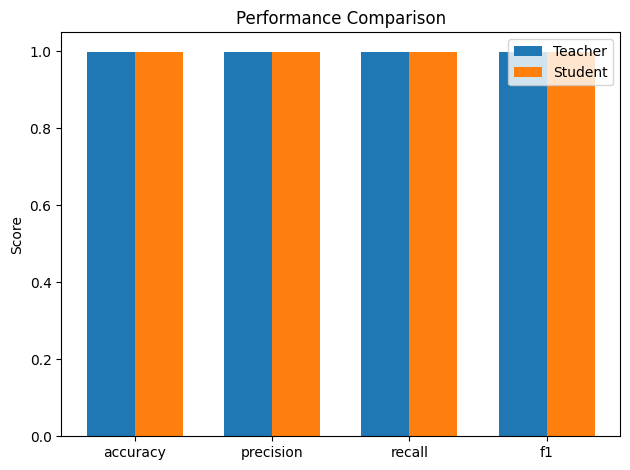

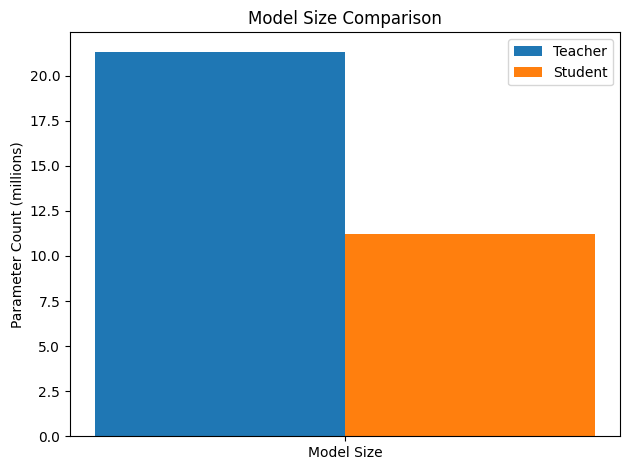

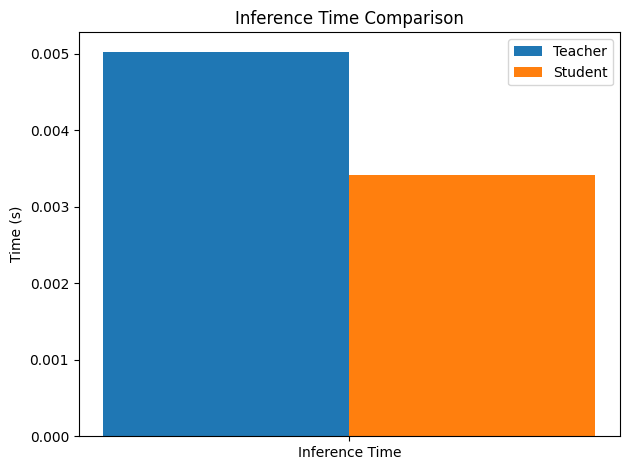

In [15]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (0.7311, 0.672), 'precision': (0.7376508696717983, 0.6772269131726946), 'recall': (0.7311, 0.672), 'f1': (0.7301654826935766, 0.6706998354831702)}


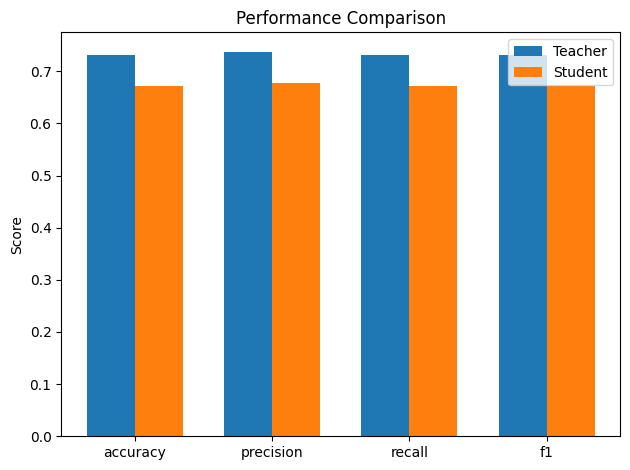

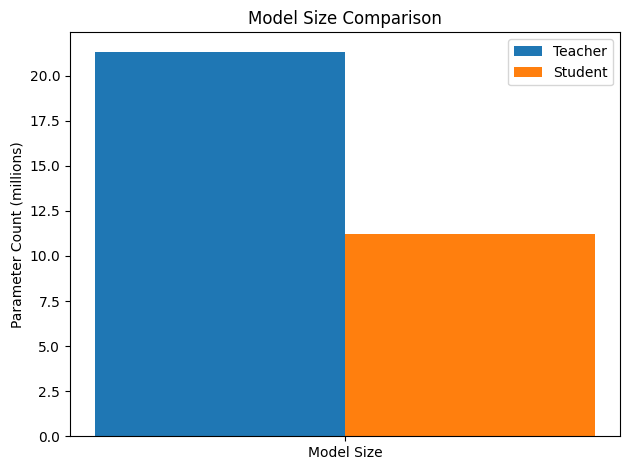

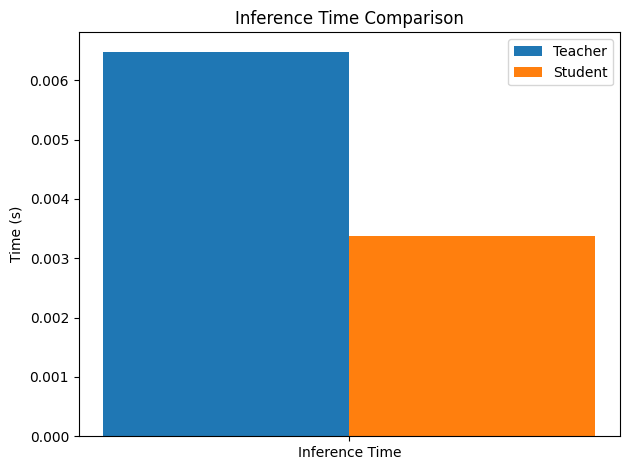

In [16]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')